In [14]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pydicom
import seaborn as sns
J = os.path.join

root = J(os.environ["DATASET_ROOT"], "bcd2022", "images_512")

In [2]:
df = pd.read_csv(J(root,"train.csv"))
df

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54701,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,0,C,49,False
54702,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,0,C,216,False
54703,1,9989,1078943060,L,CC,60.0,0,0,0,NaN,0,C,216,False
54704,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True


In [4]:
df_pos = df[df["cancer"]==1]

In [13]:
files = df_pos["patient_id"].astype(str)+"_"+df_pos["image_id"].astype(str)+".png"
for f in files:
    plt.imshow(plt.open(J(root, f)))

In [3]:
df.groupby("patient_id")["cancer"].apply(lambda x: x.sum()>0).astype(int)

patient_id
5        0
25       0
28       0
30       0
33       0
        ..
65518    0
65525    0
65526    0
65530    0
65534    0
Name: cancer, Length: 11913, dtype: int64

In [3]:
p1 = df[df.cancer==1]["patient_id"]
p2 = df[df.cancer==0]["patient_id"]

In [4]:
print(len(p1), len(p2), len(set(p1.values).intersection(set(p2.values))))

1158 53548 480


In [5]:
df[df["difficult_negative_case"]==True]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
5,2,10011,270344397,L,MLO,55.0,0,0,0,0.0,0,NaN,21,True
28,1,10049,94335194,R,MLO,52.0,0,0,0,0.0,0,C,49,True
29,1,10049,1207499426,R,MLO,52.0,0,0,0,0.0,0,C,49,True
30,1,10049,1351270472,R,CC,52.0,0,0,0,0.0,0,C,49,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54672,2,9953,1640274067,R,MLO,60.0,0,0,0,0.0,0,NaN,48,True
54673,2,9954,21064441,L,MLO,48.0,0,0,0,0.0,0,NaN,48,True
54674,2,9954,2043422318,L,CC,48.0,0,0,0,0.0,0,NaN,48,True
54704,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True


In [6]:
df[df["patient_id"]==5]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
37282,2,5,640805896,L,MLO,68.0,0,0,0,0.0,0,NaN,21,True
37283,2,5,1351088028,L,CC,68.0,0,0,0,0.0,0,NaN,21,True
37284,2,5,940388076,R,CC,68.0,0,0,0,NaN,0,NaN,21,False
37285,2,5,1633417959,R,MLO,68.0,0,0,0,NaN,0,NaN,21,False


<AxesSubplot: xlabel='image_id', ylabel='Count'>

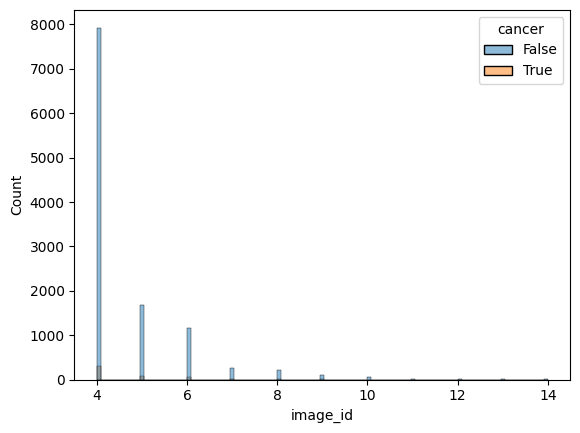

In [15]:
leak = pd.concat([df.groupby("patient_id")["image_id"].count(), df.groupby("patient_id")["cancer"].any()], axis=1)
sns.histplot(leak, x="image_id", hue="cancer")

In [22]:
for nc in range(5, 15):
    lsel = leak[leak.image_id==nc]
    print(nc, len(lsel[lsel.cancer])/len(lsel))

5 0.05036785512167515
6 0.04926108374384237
7 0.06521739130434782
8 0.034934497816593885
9 0.0707070707070707
10 0.018867924528301886
11 0.0
12 0.0
13 0.0
14 0.0


In [84]:
df_prob = pd.concat([df.groupby("patient_id")["image_id"].count(),
                     df.groupby("patient_id")["cancer"].sum(),
                     df.groupby("patient_id")["cancer"].any()], keys=["image_id", "pos_cancer", "cancer"], axis=1)
df_prob["p"] = 0
df_prob.loc[df_prob["cancer"]==1, "p"] = df_prob[df_prob["cancer"]==1]["pos_cancer"]/df_prob[df_prob["cancer"]==1]["image_id"]
df_prob[df_prob["cancer"]==1]["p"]

patient_id
106      0.5
236      0.4
283      0.5
500      0.5
729      0.5
        ... 
65222    0.6
65224    0.4
65244    0.4
65427    0.5
65492    0.5
Name: p, Length: 486, dtype: float64

# Check cancer distribution

In [58]:
def countplot(x):
    ax=sns.countplot(df, x=x, hue="cancer")
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='black', size=10)

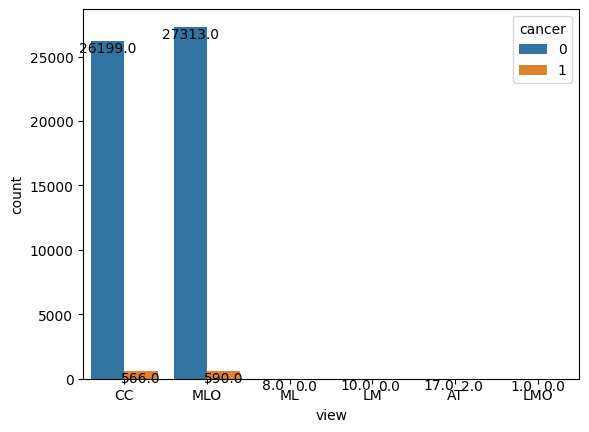

In [59]:
countplot("view")

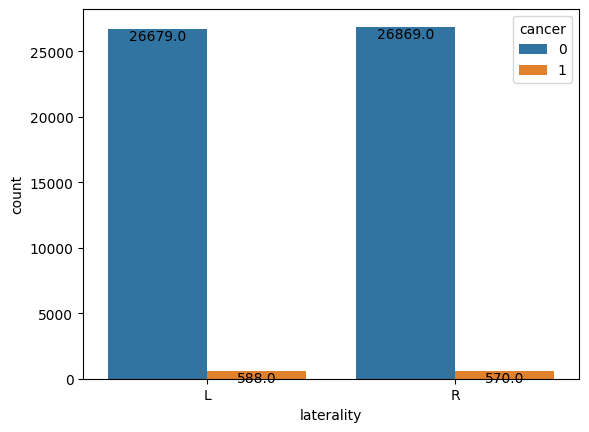

In [60]:
countplot("laterality")

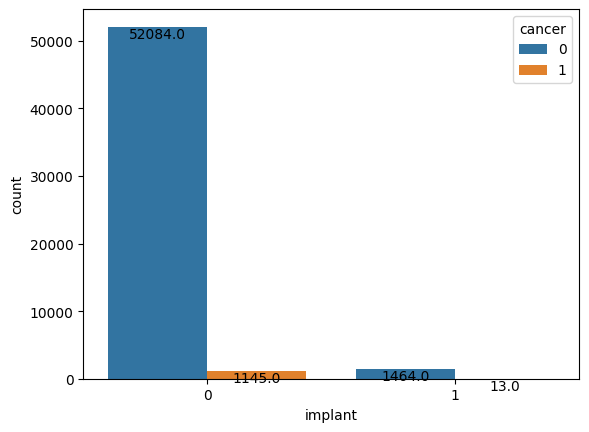

In [61]:
countplot("implant")

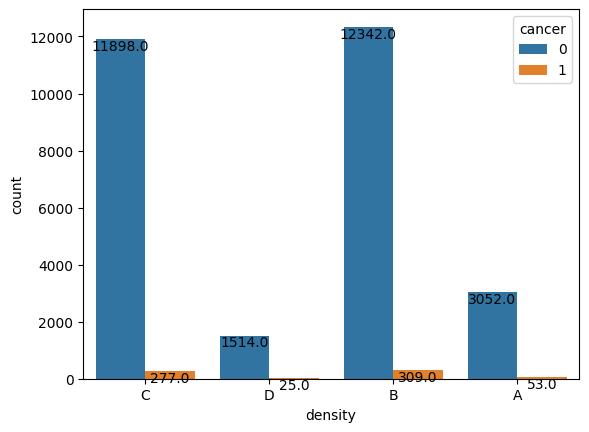

In [62]:
countplot("density")

In [11]:
df["pred"] = np.random.rand(len(df))
df["pid"] = df["patient_id"].astype(str) + "_" + df["laterality"]
df_g1 = df.groupby("pid")["pred"].sum()
df_g = df.groupby("pid")["pred"].apply(lambda x: (x >= 0.5).sum() >= len(x)*0.5).astype(int)
df_g1

pid
10006_L    1.552893
10006_R    1.558744
10011_L    0.774033
10011_R    1.231390
10025_L    1.051731
             ...   
9973_R     1.205189
997_L      0.264304
997_R      1.083062
9989_L     0.605536
9989_R     0.451664
Name: pred, Length: 23826, dtype: float64

: 

In [8]:
df_g

pid
10006_L    0
10006_R    0
10011_L    1
10011_R    0
10025_L    0
          ..
9973_R     0
997_L      1
997_R      1
9989_L     0
9989_R     0
Name: pred, Length: 23826, dtype: int64